In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Directory Info**

In [2]:
import os

# Walk through SIH direcctory and list number of files
for dirpath, dirnames, filenames in os.walk("/content/drive/MyDrive/SIH"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 4 directories and 1 images in '/content/drive/MyDrive/SIH'.
There are 8 directories and 0 images in '/content/drive/MyDrive/SIH/Train'.
There are 0 directories and 1044 images in '/content/drive/MyDrive/SIH/Train/melanoma'.
There are 0 directories and 1071 images in '/content/drive/MyDrive/SIH/Train/pigmented benign keratosis'.
There are 0 directories and 128 images in '/content/drive/MyDrive/SIH/Train/dermatofibroma'.
There are 0 directories and 184 images in '/content/drive/MyDrive/SIH/Train/squamous cell carcinoma'.
There are 0 directories and 498 images in '/content/drive/MyDrive/SIH/Train/basal cell carcinoma'.
There are 0 directories and 144 images in '/content/drive/MyDrive/SIH/Train/vascular lesion'.
There are 0 directories and 120 images in '/content/drive/MyDrive/SIH/Train/actinic keratosis'.
There are 0 directories and 1460 images in '/content/drive/MyDrive/SIH/Train/nevus'.
There are 8 directories and 0 images in '/content/drive/MyDrive/SIH/Test'.
There are 0 dire

In [3]:
# Setting up the training and test directory paths.
train_dir = "/content/drive/MyDrive/SIH/Train/"
test_dir = "/content/drive/MyDrive/SIH/Test/"

 > **Class Names**

In [4]:
# Get the class names for our multi-class dataset
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)


['actinic keratosis' 'basal cell carcinoma' 'dermatofibroma' 'melanoma'
 'nevus' 'pigmented benign keratosis' 'squamous cell carcinoma'
 'vascular lesion']


# **Visualize !!**

In [5]:
# View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random, os

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (450, 600, 3)


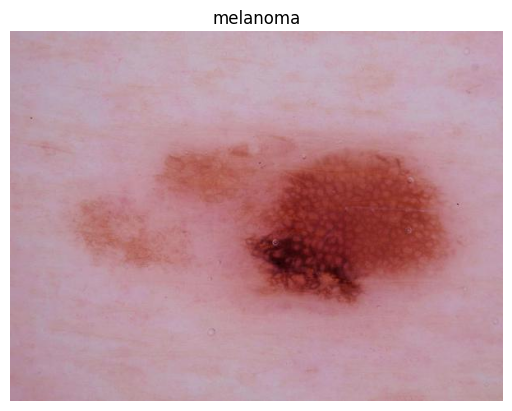

In [6]:
# View a random image from the training dataset
img = view_random_image(target_dir="/content/drive/MyDrive/SIH/Train/",
                        target_class="melanoma")

# **Fetch Train and Test Image Data**

In [7]:
# Preprocess the data (prepare it for a model)
from tensorflow.keras.preprocessing.image import ImageDataGenerator



# Rescale the data and create data generator instances
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Load data in from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(450, 600),
                                               batch_size=32,
                                               class_mode='categorical') # changed to categorical

test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=(450, 600),
                                              batch_size=32,
                                              class_mode='categorical')

Found 4649 images belonging to 8 classes.
Found 1158 images belonging to 8 classes.


# **Model Definition**

In [8]:
# Creating a baseline model  #### GREAT
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

# Create our model (a clone of model_8, except to be multi-class)
model_1 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(450, 600, 3)),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(8, activation='softmax') # changed to have 8 neurons (same as number of classes) and 'softmax' activation
])

# Compile the model
model_1.compile(loss="categorical_crossentropy", # changed to categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit baseline model
history_1 = model_1.fit(train_data, # now 8 different classes
                        epochs=10,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/10
146/146 [==============================] - 1468s 10s/step - loss: 1.5595 - accuracy: 0.4158 - val_loss: 1.4174 - val_accuracy: 0.4568
Epoch 2/10
146/146 [==============================] - 60s 408ms/step - loss: 1.3433 - accuracy: 0.4896 - val_loss: 1.4352 - val_accuracy: 0.4758
Epoch 3/10
146/146 [==============================] - 60s 409ms/step - loss: 1.2506 - accuracy: 0.5285 - val_loss: 1.4171 - val_accuracy: 0.4732
Epoch 4/10
146/146 [==============================] - 60s 412ms/step - loss: 1.0915 - accuracy: 0.5963 - val_loss: 1.4581 - val_accuracy: 0.4594
Epoch 5/10
146/146 [==============================] - 58s 394ms/step - loss: 0.9295 - accuracy: 0.6623 - val_loss: 1.5201 - val_accuracy: 0.5250
Epoch 6/10
146/146 [==============================] - 60s 410ms/step - loss: 0.7331 - accuracy: 0.7410 - val_loss: 1.8729 - val_accuracy: 0.4896
Epoch 7/10
146/146 [==============================] - 58s 399ms/step - loss: 0.5684 - accuracy: 0.8019 - val_loss: 2.2842 - val_ac

# **Curve Plotting**

In [9]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

In [10]:
# Evaluate on the test data
model_1.evaluate(test_data)

37/37 [==============================] - 11s 287ms/step - loss: 3.5307 - accuracy: 0.4862


[3.5306999683380127, 0.4861830770969391]

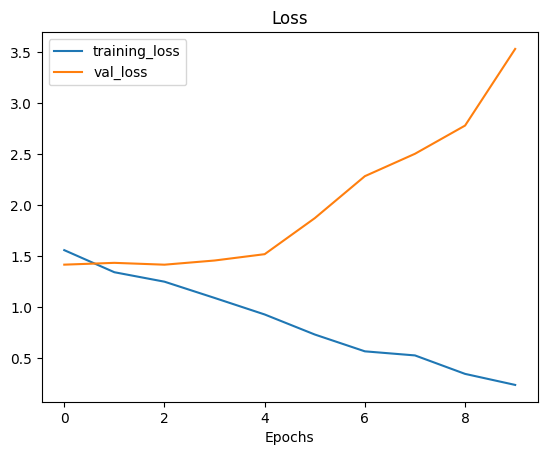

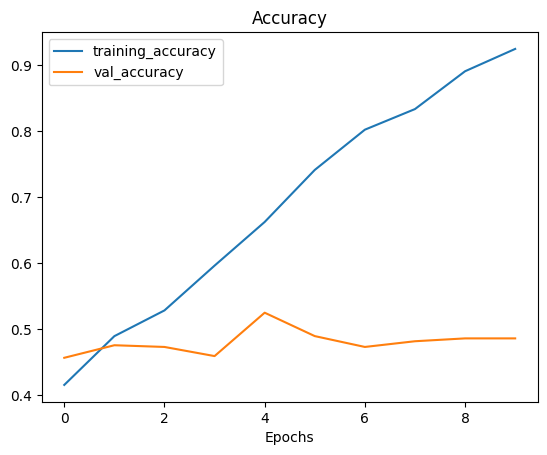

In [11]:
# Check out the model's loss curves on the 8 classes of data
plot_loss_curves(history_1)

# **Predict on New Image Data**

In [12]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=[450, 600]):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = img_shape)

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [13]:
# Function to work with multi-class
def pred_and_plot(model, filename, class_names, img_shape=[450, 600]):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename, img_shape)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))
  print(pred)

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

1/1 [==============================] - 0s 265ms/step
[[0.0000000e+00 1.0000000e+00 0.0000000e+00 2.2710420e-25 1.8223292e-25
  1.2091756e-20 1.3453644e-38 6.1315873e-30]]


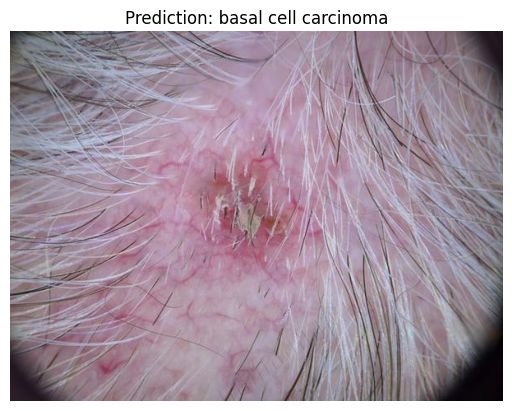

In [14]:
pred_and_plot(model_1, "/content/drive/MyDrive/SIH/try/basal cell carcinoma.JPG", class_names)

1/1 [==============================] - 0s 28ms/step
[[9.3435317e-14 3.0704395e-14 1.9999255e-10 4.7460794e-01 3.5080603e-01
  1.7458598e-01 8.6003132e-10 4.9705814e-14]]


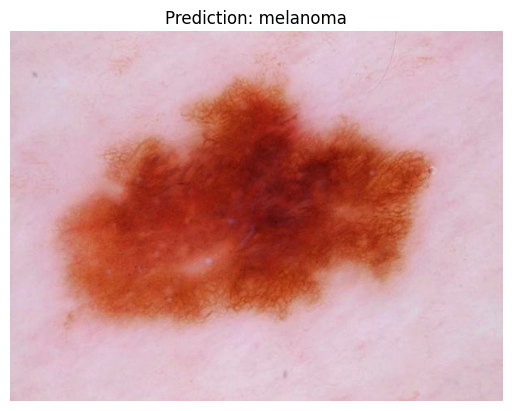

In [15]:
pred_and_plot(model_1, "/content/drive/MyDrive/SIH/try/melanoma.JPG", class_names)

1/1 [==============================] - 0s 21ms/step
[[1.5360933e-12 5.2616819e-13 2.2304474e-18 3.9185309e-07 3.2156300e-12
  6.2569100e-15 9.9999964e-01 5.5096557e-27]]


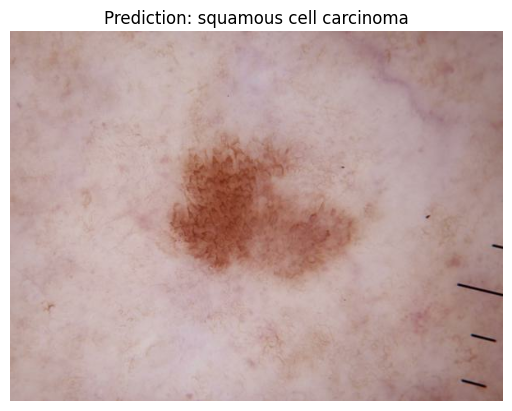

In [16]:
pred_and_plot(model_1, "/content/drive/MyDrive/SIH/try/squamous cell carcinoma.JPG", class_names)

1/1 [==============================] - 0s 19ms/step
[[9.9594730e-01 5.9110142e-05 9.6729145e-06 3.5802266e-05 3.2209762e-05
  3.9106030e-03 5.3394665e-06 1.9095530e-08]]


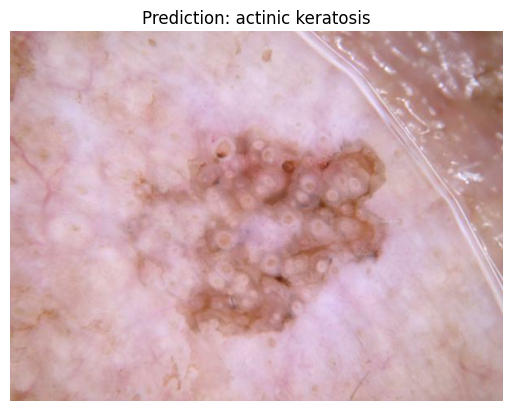

In [17]:
pred_and_plot(model_1, "/content/drive/MyDrive/SIH/try/actinic keratosis.JPG", class_names)

1/1 [==============================] - 0s 33ms/step
[[6.4763389e-11 1.2831073e-09 3.6579186e-12 8.0189013e-05 3.0431719e-04
  9.9961543e-01 2.6305678e-08 7.3836559e-10]]


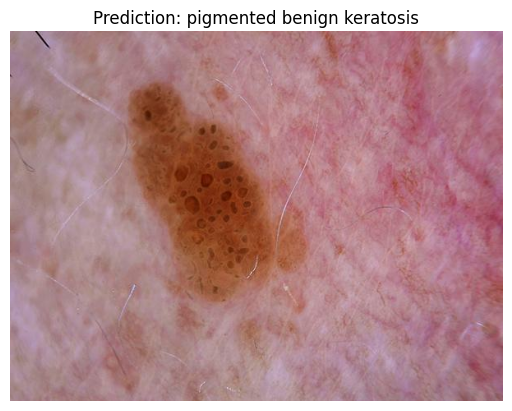

In [18]:
pred_and_plot(model_1, "/content/drive/MyDrive/SIH/try/pigmented benign keratosis.JPG", class_names)

1/1 [==============================] - 0s 20ms/step
[[1.5118116e-03 5.6149974e-03 6.3948208e-01 3.3559099e-02 4.6721091e-03
  3.1345698e-01 4.7198651e-04 1.2309897e-03]]


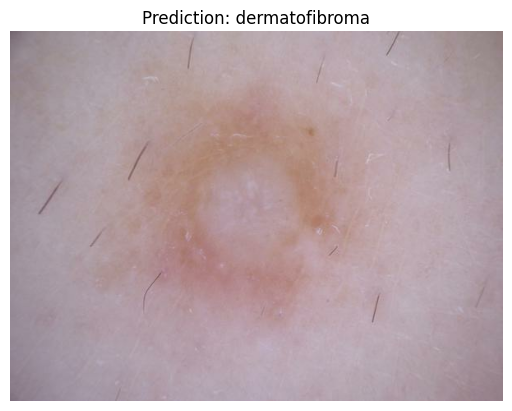

In [19]:
pred_and_plot(model_1, "/content/drive/MyDrive/SIH/try/dermatofibroma.JPG", class_names)

1/1 [==============================] - 0s 19ms/step
[[1.48587675e-08 2.50775756e-08 1.84481621e-13 5.84301706e-05
  1.11166955e-04 2.59670079e-01 5.00441855e-10 7.40160286e-01]]


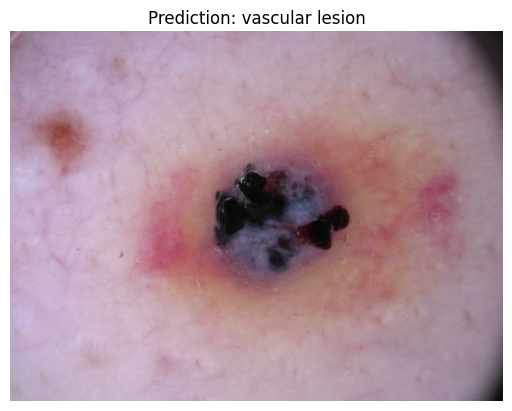

In [20]:
pred_and_plot(model_1, "/content/drive/MyDrive/SIH/try/vascular lesion.JPG", class_names)

1/1 [==============================] - 0s 19ms/step
[[2.6741489e-05 2.2297096e-05 6.5614789e-04 2.3542934e-06 9.9326563e-01
  6.0250689e-03 6.5928776e-07 1.0008695e-06]]


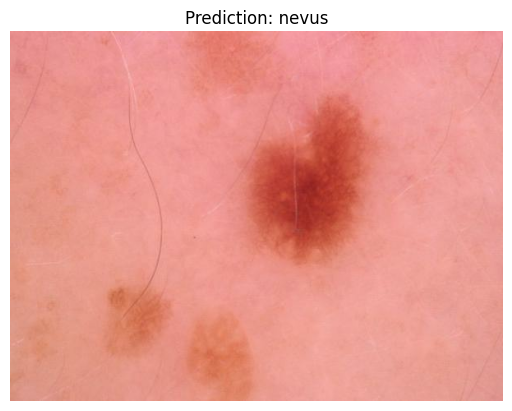

In [21]:
pred_and_plot(model_1, "/content/drive/MyDrive/SIH/try/nevus.JPG", class_names)